# demo

In [1]:
import keras
from keras.utils import plot_model

Using TensorFlow backend.


In [0]:
!mkdir imgs

In [5]:
model_paths = ['intent_classification', 'lang_identification', 'ner', 'sent_polarity', 'senti_analysis', 'spam_email', 'spam_sms', 'text_classification']

for i in model_paths:
  with open('{}.json'.format(i), 'r') as f:
    model_json = f.read()
  model = keras.models.model_from_json(model_json)
  plot_model(model, to_file="imgs/{}.png".format(i))
  print('Done {}'.format(i))

Done intent_classification
Done lang_identification
Done ner
Done sent_polarity
Done senti_analysis
Done spam_email
Done spam_sms
Done text_classification


In [9]:
!zip imgs.zip imgs/

  adding: imgs/ (stored 0%)


# Load data from drive

In [10]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 1.9MB/s 


In [11]:
file_id = '1gmvTm4Ah7zKMoaYwX_YhqE0ugbW6ZFYg'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content "{}"'.format(downloaded.GetContentFile('id_data.zip')))

Downloaded content "None"


In [0]:
!mkdir id_data
!unzip -d id_data/ id_data.zip

# Data Processing

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob

In [15]:
img_paths = glob.glob('id_data/id_data/*/*')

img_paths[:5]

['id_data/id_data/passport/00000180.jpg',
 'id_data/id_data/passport/00000174.jpg',
 'id_data/id_data/passport/00000276.jpg',
 'id_data/id_data/passport/00000048.jpg',
 'id_data/id_data/passport/00000133.png']

In [17]:
np.random.seed(0)
np.random.shuffle(img_paths)

img_paths[:5]

['id_data/id_data/passport/00000390.jpg',
 'id_data/id_data/drivers_license/00000028.jpg',
 'id_data/id_data/passport/00000071.png',
 'id_data/id_data/drivers_license/00000156.jpg',
 'id_data/id_data/drivers_license/00000339.jpg']

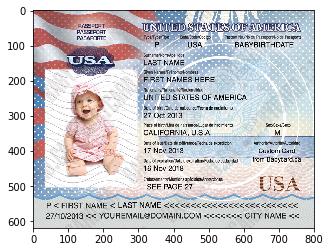

In [18]:
img = mpimg.imread(img_paths[0])
imgplot = plt.imshow(img)
plt.show()

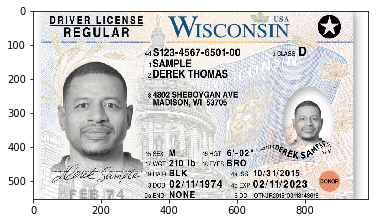

In [19]:
img = mpimg.imread(img_paths[1])
imgplot = plt.imshow(img)
plt.show()

All dimensions are different need to make it consistent

In [21]:
img_paths[0].split('/')[-2], img_paths[1].split('/')[-2]

('passport', 'drivers_license')

In [0]:
import cv2
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [0]:
def make_data_labels(image_paths):
  """Function to make the data and labels."""
  data = []
  labels = []
  for img_path in image_paths:
    img = cv2.imread(img_path)
    img = cv2.resize(img, (28, 28)) # resize the image
    img = img_to_array(img)
    data.append(img)
    
    label_name = img_path.split('/')[-2]
    if label_name == 'passport':
      label = 0
    elif label_name == 'drivers_license':
      label = 1
    labels.append(label)
  data = np.array(data, dtype="float32") / 255.0 # normalize the images
  labels = to_categorical(np.asarray(labels), num_classes=2)
  return data, labels

In [42]:
data, labels = make_data_labels(img_paths)
data.shape, labels.shape

((564, 28, 28, 3), (564, 2))

In [0]:
def data_augmentation():
  """Function for data augmentation."""
  aug = ImageDataGenerator(
      zca_epsilon=1e-9,
      rotation_range=270,
      width_shift_range=2,
      height_shift_range=2,
      brightness_range=(-0.5, 1.5),
      shear_range=0.2,
      zoom_range=0.4,
      channel_shift_range=0.2,
      fill_mode='nearest',
      horizontal_flip=1,
      vertical_flip=1    
  )
  return aug

def data_augmentation_2():
  """Function for data augmentation 2."""
  aug = ImageDataGenerator(
      rotation_range=30,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode="nearest"
  )
  return aug

In [0]:
aug = data_augmentation_2()

In [44]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, stratify=list(labels), random_state=42, shuffle=True, test_size=0.2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((451, 28, 28, 3), (451, 2), (113, 28, 28, 3), (113, 2))

# Model

In [0]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense
from keras import backend as K
import keras

In [0]:
def build_model(width, height, depth, num_classes):
  """Function to build the model."""
  
  input_shape = (height, width, depth)
   
  # start
  model = Sequential()
  kernel_init = 'glorot_uniform'
  activ = 'relu'
  bias_init = 'zeros'
  filters_ = 32
  filter_size = (3, 3)
  strides = (1, 1)
  pad = 'same'
  dilate = (1, 1)
  pool_ = (2, 2)
  
  # setting blocks conv -> activation -> maxpool
  for i in range(1, 3):
    model.add(Conv2D(filters_*i, filter_size, strides=strides, padding=pad, input_shape=input_shape, kernel_initializer=kernel_init, bias_initializer=bias_init, dilation_rate=dilate ))
    model.add(Activation(activ))
    model.add(MaxPooling2D(pool_size=pool_))
    
  # blocks including Fully connected layer
  model.add(Flatten())
  model.add(Dense(300, kernel_initializer=kernel_init, bias_initializer=bias_init))
  model.add(Activation("relu"))
  
  # classifier layer
  model.add(Dense(num_classes))
  model.add(Activation("softmax"))
  
  return model

In [30]:
model = build_model(28, 28, 3, 2)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
__________

In [0]:
from keras.utils import plot_model

In [0]:
plot_model(model, to_file='classification_model.png')

# Training

In [0]:
import matplotlib
matplotlib.use("Agg")
import random

In [0]:
epochs_ = 100
lr_init = 1e-4
batch_ = 32

In [0]:
# define the optimizer
opt = keras.optimizers.Adam(lr=lr_init, decay=(lr_init/epochs_))
loss = keras.losses.categorical_crossentropy

In [0]:
model.compile(loss=loss, optimizer='rmsprop', metrics=['accuracy'])

In [0]:
def plot_summary(H, epochs_):
  """Function to plot the training summary."""
  plt.style.use("ggplot")
  plt.figure(figsize=(9, 6))
  N = epochs_
  
  for i in zip(['loss', 'val_loss', 'acc', 'val_acc'], ['train_loss', 'val_loss', 'train_acc', 'val_acc']):
    plt.plot(np.arange(0, N), H.history[i[0]], label=i[1])
  plt.title("Training loss and Accuracy")
  plt.xlabel('Epoch #')
  plt.ylabel("Loss/Accuracy")
  plt.legend(loc="lower left")
  plt.show()

In [38]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11869859366181331178
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15195440916254825935
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1674541388216921762
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14800692839
locality {
  bus_id: 1
  links {
  }
}
incarnation: 810323646072658960
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [39]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [45]:
H = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=batch_),
    validation_data=(x_test, y_test),
    steps_per_epoch=100,
    epochs=epochs_,
    verbose=2
)

Epoch 1/100
 - 5s - loss: 0.6614 - acc: 0.6415 - val_loss: 0.5468 - val_acc: 0.7522
Epoch 2/100
 - 1s - loss: 0.4758 - acc: 0.7835 - val_loss: 0.4898 - val_acc: 0.7965
Epoch 3/100
 - 1s - loss: 0.4530 - acc: 0.7957 - val_loss: 0.8191 - val_acc: 0.7168
Epoch 4/100
 - 1s - loss: 0.3819 - acc: 0.8279 - val_loss: 0.5683 - val_acc: 0.8053
Epoch 5/100
 - 1s - loss: 0.3569 - acc: 0.8489 - val_loss: 0.6268 - val_acc: 0.8053
Epoch 6/100
 - 1s - loss: 0.3149 - acc: 0.8690 - val_loss: 0.6696 - val_acc: 0.7965
Epoch 7/100
 - 1s - loss: 0.2965 - acc: 0.8658 - val_loss: 0.9136 - val_acc: 0.7699
Epoch 8/100
 - 1s - loss: 0.3085 - acc: 0.8638 - val_loss: 0.6191 - val_acc: 0.8053
Epoch 9/100
 - 1s - loss: 0.2761 - acc: 0.8776 - val_loss: 0.8471 - val_acc: 0.8053
Epoch 10/100
 - 1s - loss: 0.2681 - acc: 0.8838 - val_loss: 1.0012 - val_acc: 0.7788
Epoch 11/100
 - 1s - loss: 0.2589 - acc: 0.8869 - val_loss: 1.1160 - val_acc: 0.7699
Epoch 12/100
 - 1s - loss: 0.2523 - acc: 0.8916 - val_loss: 0.6054 - val_a

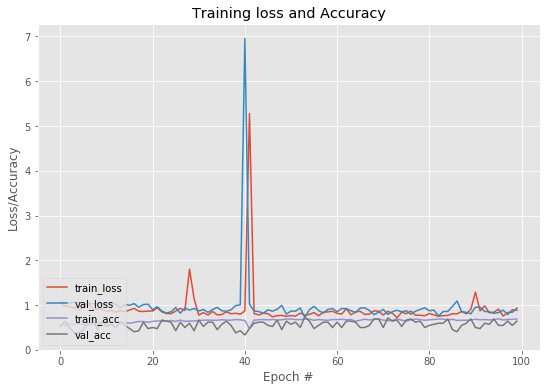

In [0]:
plot_summary(H, epochs_)

Lets try with some other network architecture

# Model LeNet

In [0]:
def LeNet(width, height, depth, classes):
  """Function to build LeNet model."""
  
  inputShape = (height, width, depth)
  
  model = Sequential()
  
  # model block 1
  model.add(Conv2D(20, (5, 5), padding="same", input_shape=inputShape))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # model block 2
  model.add(Conv2D(50, (5, 5), padding="same"))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  
  # FC layer
  model.add(Flatten())
  model.add(Dense(500))
  model.add(Activation("relu"))
  
  # classifier layer
  model.add(Dense(classes))
  model.add(Activation("softmax"))
  
  return model

In [0]:
epochs_ = 50
init_lr = 1e-3
batch_ = 32

In [52]:
le_net = build_model(28, 28, 3, 2)
le_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
activation_9 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_10 (Activation)   (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)              0         
__________

In [0]:
opt = keras.optimizers.Adam(lr=init_lr, decay=init_lr/epochs_)

In [0]:
le_net.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [54]:
H = le_net.fit_generator(
    aug.flow(x_train, y_train, batch_size=batch_),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train)//batch_,
    epochs=epochs_,
    verbose=2
)

Epoch 1/50
 - 1s - loss: 0.7671 - acc: 0.5223 - val_loss: 0.6675 - val_acc: 0.5752
Epoch 2/50
 - 0s - loss: 0.6667 - acc: 0.5583 - val_loss: 0.6261 - val_acc: 0.5841
Epoch 3/50
 - 0s - loss: 0.6043 - acc: 0.6794 - val_loss: 0.6912 - val_acc: 0.5929
Epoch 4/50
 - 0s - loss: 0.6082 - acc: 0.6660 - val_loss: 0.5271 - val_acc: 0.8053
Epoch 5/50
 - 0s - loss: 0.5606 - acc: 0.6817 - val_loss: 0.6277 - val_acc: 0.6726
Epoch 6/50
 - 0s - loss: 0.4862 - acc: 0.7825 - val_loss: 0.7515 - val_acc: 0.6726
Epoch 7/50
 - 0s - loss: 0.4314 - acc: 0.8116 - val_loss: 0.7716 - val_acc: 0.6991
Epoch 8/50
 - 0s - loss: 0.4762 - acc: 0.7780 - val_loss: 0.5722 - val_acc: 0.7965
Epoch 9/50
 - 0s - loss: 0.4654 - acc: 0.7713 - val_loss: 0.6181 - val_acc: 0.7434
Epoch 10/50
 - 0s - loss: 0.4184 - acc: 0.8117 - val_loss: 0.6777 - val_acc: 0.7434
Epoch 11/50
 - 0s - loss: 0.4411 - acc: 0.7982 - val_loss: 0.7561 - val_acc: 0.7257
Epoch 12/50
 - 0s - loss: 0.4600 - acc: 0.7758 - val_loss: 0.7639 - val_acc: 0.7168
E

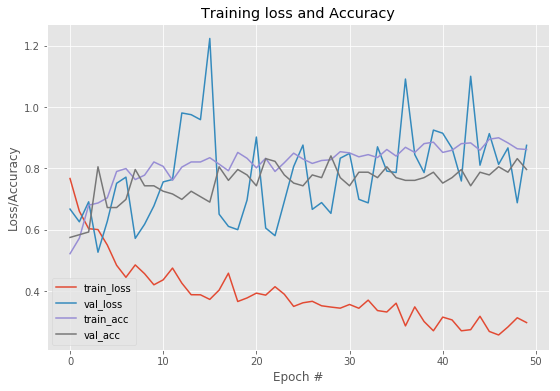

In [55]:
plot_summary(H, epochs_)

Okay, even here it is not learning. Lets modify the data augmentations and check.

In [0]:
epochs_ = 100
init_lr = 1e-3
batch_ = 32

In [0]:
le_net = build_model(28, 28, 3, 2)
le_net.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [60]:
H = le_net.fit_generator(
    aug.flow(x_train, y_train, batch_size=batch_),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train)//batch_,
    epochs=epochs_,
    verbose=2
)

Epoch 1/100
 - 1s - loss: 0.8567 - acc: 0.5647 - val_loss: 0.6287 - val_acc: 0.5752
Epoch 2/100
 - 0s - loss: 0.5560 - acc: 0.7220 - val_loss: 0.5173 - val_acc: 0.7876
Epoch 3/100
 - 0s - loss: 0.5323 - acc: 0.7197 - val_loss: 0.5528 - val_acc: 0.7876
Epoch 4/100
 - 0s - loss: 0.4933 - acc: 0.7668 - val_loss: 0.8505 - val_acc: 0.6372
Epoch 5/100
 - 0s - loss: 0.5286 - acc: 0.7310 - val_loss: 0.8611 - val_acc: 0.6726
Epoch 6/100
 - 0s - loss: 0.4940 - acc: 0.7937 - val_loss: 0.5975 - val_acc: 0.7611
Epoch 7/100
 - 0s - loss: 0.4946 - acc: 0.7691 - val_loss: 0.5355 - val_acc: 0.8053
Epoch 8/100
 - 0s - loss: 0.4572 - acc: 0.7802 - val_loss: 0.5431 - val_acc: 0.8053
Epoch 9/100
 - 0s - loss: 0.4072 - acc: 0.8139 - val_loss: 0.6590 - val_acc: 0.7434
Epoch 10/100
 - 0s - loss: 0.4556 - acc: 0.7982 - val_loss: 0.5208 - val_acc: 0.7876
Epoch 11/100
 - 0s - loss: 0.4426 - acc: 0.7915 - val_loss: 0.6002 - val_acc: 0.7611
Epoch 12/100
 - 0s - loss: 0.4892 - acc: 0.7758 - val_loss: 0.6521 - val_a

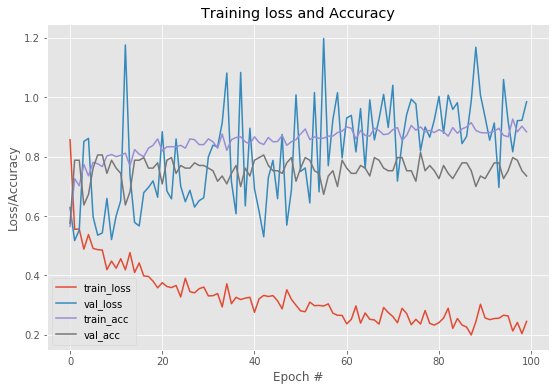

In [61]:
plot_summary(H, epochs_)

Lets try with RMSprop

In [0]:
le_net = build_model(28, 28, 3, 2)
le_net.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["accuracy"])

In [63]:
H = le_net.fit_generator(
    aug.flow(x_train, y_train, batch_size=batch_),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train)//batch_,
    epochs=epochs_,
    verbose=2
)

Epoch 1/100
 - 1s - loss: 1.0784 - acc: 0.5402 - val_loss: 0.7233 - val_acc: 0.4248
Epoch 2/100
 - 0s - loss: 0.7083 - acc: 0.5629 - val_loss: 1.0540 - val_acc: 0.5752
Epoch 3/100
 - 0s - loss: 0.7018 - acc: 0.5919 - val_loss: 0.6478 - val_acc: 0.5752
Epoch 4/100
 - 0s - loss: 0.6331 - acc: 0.6413 - val_loss: 0.8567 - val_acc: 0.5752
Epoch 5/100
 - 0s - loss: 0.5762 - acc: 0.6682 - val_loss: 0.5393 - val_acc: 0.7788
Epoch 6/100
 - 0s - loss: 0.6076 - acc: 0.6749 - val_loss: 0.5282 - val_acc: 0.7788
Epoch 7/100
 - 0s - loss: 0.5232 - acc: 0.7668 - val_loss: 0.9423 - val_acc: 0.6372
Epoch 8/100
 - 0s - loss: 0.6107 - acc: 0.6974 - val_loss: 0.8325 - val_acc: 0.6549
Epoch 9/100
 - 0s - loss: 0.5306 - acc: 0.7466 - val_loss: 0.7119 - val_acc: 0.7257
Epoch 10/100
 - 0s - loss: 0.5474 - acc: 0.7131 - val_loss: 0.5260 - val_acc: 0.7876
Epoch 11/100
 - 0s - loss: 0.5273 - acc: 0.7220 - val_loss: 0.5451 - val_acc: 0.7699
Epoch 12/100
 - 0s - loss: 0.4494 - acc: 0.7892 - val_loss: 0.6613 - val_a

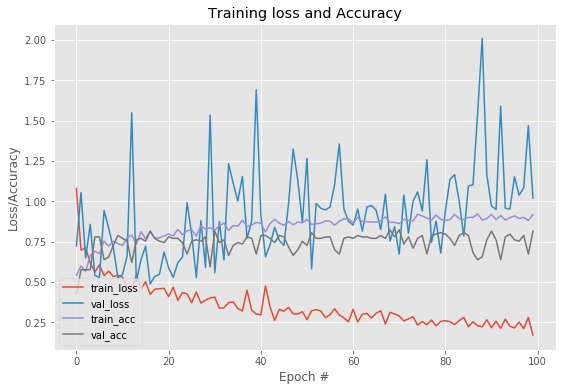

In [64]:
plot_summary(H, epochs_)

Validation loss is all over the place  :-| 